Engineer: Adeola Odunewu
Intern: FlipRobo LLC DS1123
Project: Baseball Win Prediction

In [ ]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVR
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message=".*deprecated.*")
on

In [3]:
# Loading Data
url = 'https://github.com/FlipRoboTechnologies/ML_-Datasets/raw/main/Baseball/baseball.csv'
df = pd.read_csv(url)
df.head()

,W,R,AB,H,2B,3B,HR,BB,SO,SB,RA,ER,ERA,CG,SHO,SV,E
0,95,724,5575,1497,300,42,139,383,973,104,641,601,3.73,2,8,56,88
1,83,696,5467,1349,277,44,156,439,1264,70,700,653,4.07,2,12,45,86
2,81,669,5439,1395,303,29,141,533,1157,86,640,584,3.67,11,10,38,79
3,76,622,5533,1381,260,27,136,404,1231,68,701,643,3.98,7,9,37,101
4,74,689,5605,1515,289,49,151,455,1259,83,803,746,4.64,7,12,35,86


In [44]:
# Calculating descriptive statistics for the W (wins) column in the DataFrame
df['W'].describe()

count     30.000000
mean      80.966667
std       10.453455
min       63.000000
25%       74.000000
50%       81.000000
75%       87.750000
max      100.000000
Name: W, dtype: float64

<Axes: xlabel='W', ylabel='Density'>

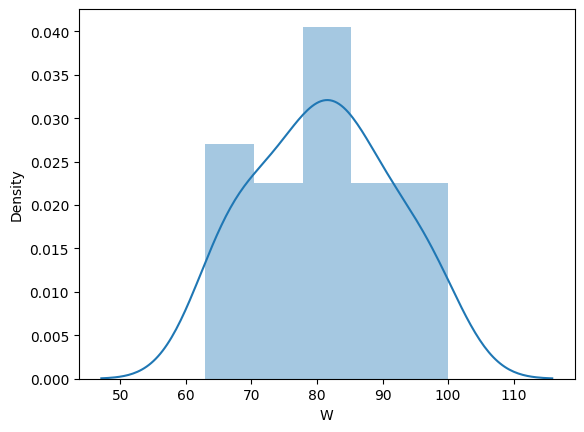

In [46]:
# Create a distribution plot (histogram and kernel density estimation) for the W (wins) column in the DataFrame
sns.distplot(df['W'])

The column displayed symmetrical attributes.

In [95]:
# Checking for missing data
df.isnull().sum()

W      0
R      0
AB     0
H      0
2B     0
3B     0
HR     0
BB     0
SO     0
SB     0
RA     0
ER     0
ERA    0
CG     0
SHO    0
SV     0
E      0
dtype: int64

In [47]:
# Selecting variables for bivariate analysis and calculate descriptive statistics
rela_check = df[['W', 'R', 'ERA']]
rela_check.describe()

,W,R,ERA
count,30.000000,30.000000,30.000000
mean,80.966667,688.233333,3.956333
std,10.453455,58.761754,0.454089
min,63.000000,573.000000,2.940000
25%,74.000000,651.250000,3.682500
50%,81.000000,689.000000,4.025000
75%,87.750000,718.250000,4.220000
max,100.000000,891.000000,5.040000


<Axes: >

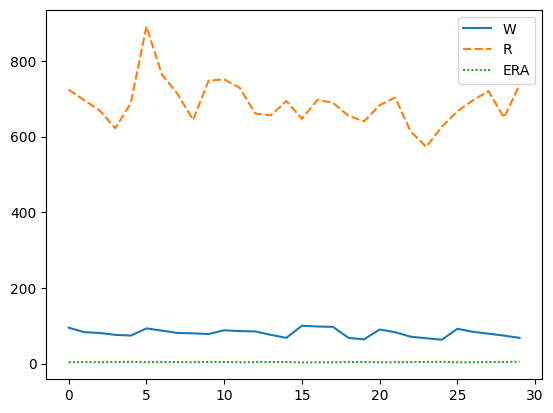

In [51]:
# Create a line plot to visualize the relationship between Wins(W), Runs Scored(R), and Earned Run Average(ERA)
sns.lineplot(data=rela_check)

In [53]:
# Computing the correlation matrix
correlation_matrix = rela_check.corr()

# Display the correlation matrix
print(correlation_matrix)

            W         R       ERA
W    1.000000  0.430751 -0.819600
R    0.430751  1.000000 -0.049281
ERA -0.819600 -0.049281  1.000000


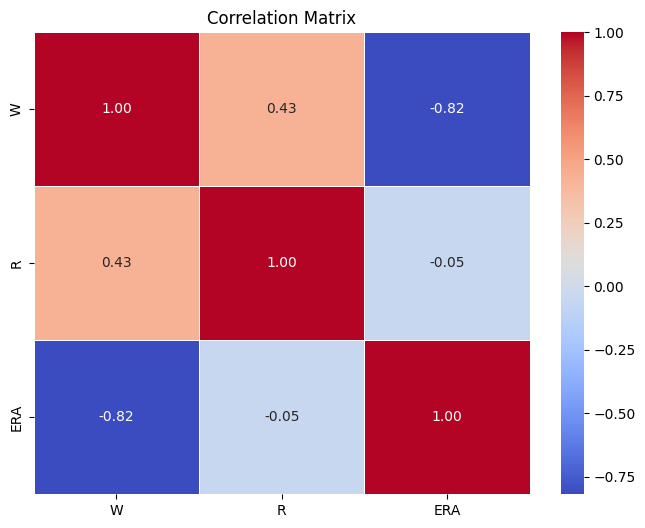

In [54]:
# Plot correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

W and R (r ≈ 0.43): This suggests that teams that score more 
runs tend to win more games.

There is a strong -tive correlation between W and ERA. 
This indicates that teams with lower earned run averages, tend to win more games. 
Pitching performance plays a significant role in determining a team's success.

R and ERA (r ≈ -0.05): There's little to no relationship between the number
of runs scored and the earned run average. This suggests that R and ERA may not
directly influence each other to a significant extent.

In [60]:
import statsmodels.api as sm

# Ensuring reproducibility of results across different runs.
np.random.seed(123)
X = df[['R', 'ERA']]  # Independent variables
y = df[['W']]  # Dependent variable

# Adding a constant to the independent variable matrix for the intercept term
X = sm.add_constant(X)

# Fitting the regression model
model = sm.OLS(y, X).fit()

# Printing the summary of the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     63.42
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           6.28e-11
Time:                        18:03:03   Log-Likelihood:                -86.366
No. Observations:                  30   AIC:                             178.7
Df Residuals:                      27   BIC:                             182.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        105.9481     12.632      8.387      0.0

Based on this summary, the regression model appears to be statistically significant,
with both Run and ERA having substantial effects on Win. Additionally,
the diagnostic tests for normality of residuals and autocorrelation do not indicate 
any significant issues.

In [3]:
# Checking the data type
df.dtypes

W        int64
R        int64
AB       int64
H        int64
2B       int64
3B       int64
HR       int64
BB       int64
SO       int64
SB       int64
RA       int64
ER       int64
ERA    float64
CG       int64
SHO      int64
SV       int64
E        int64
dtype: object

The dataset comprises both float and integer variables.

In [4]:
# Checking for missing data
df.isnull().sum()

W      0
R      0
AB     0
H      0
2B     0
3B     0
HR     0
BB     0
SO     0
SB     0
RA     0
ER     0
ERA    0
CG     0
SHO    0
SV     0
E      0
dtype: int64

There are no missing data present in the dataset.

In [61]:
df.skew()

W      0.047089
R      1.200786
AB     0.183437
H      0.670254
2B    -0.230650
3B     0.129502
HR     0.516441
BB     0.158498
SO    -0.156065
SB     0.479893
RA     0.045734
ER     0.058710
ERA    0.053331
CG     0.736845
SHO    0.565790
SV     0.657524
E      0.890132
dtype: float64

In general, positive skewness indicates that the distribution of values is skewed 
towards the lower end, with a longer right tail. Negative skewness suggests the 
opposite, with a longer left tail. 

The magnitude of skewness indicates the degree of asymmetry, with larger values 
indicating more pronounced skewness.

More Essetially: 
Win slightly positively skewed: This suggests that most teams may have fewer wins than 
the mean, with a few teams having exceptionally high win counts.

Home Runs (HR): positively skewed: Implies that most teams may have fewer home runs
than the average, with some teams having significantly more.

Runs (R): moderately positively skewed: Indicates that most teams tend to score fewer 
runs than the average, with some teams scoring significantly higher runs.

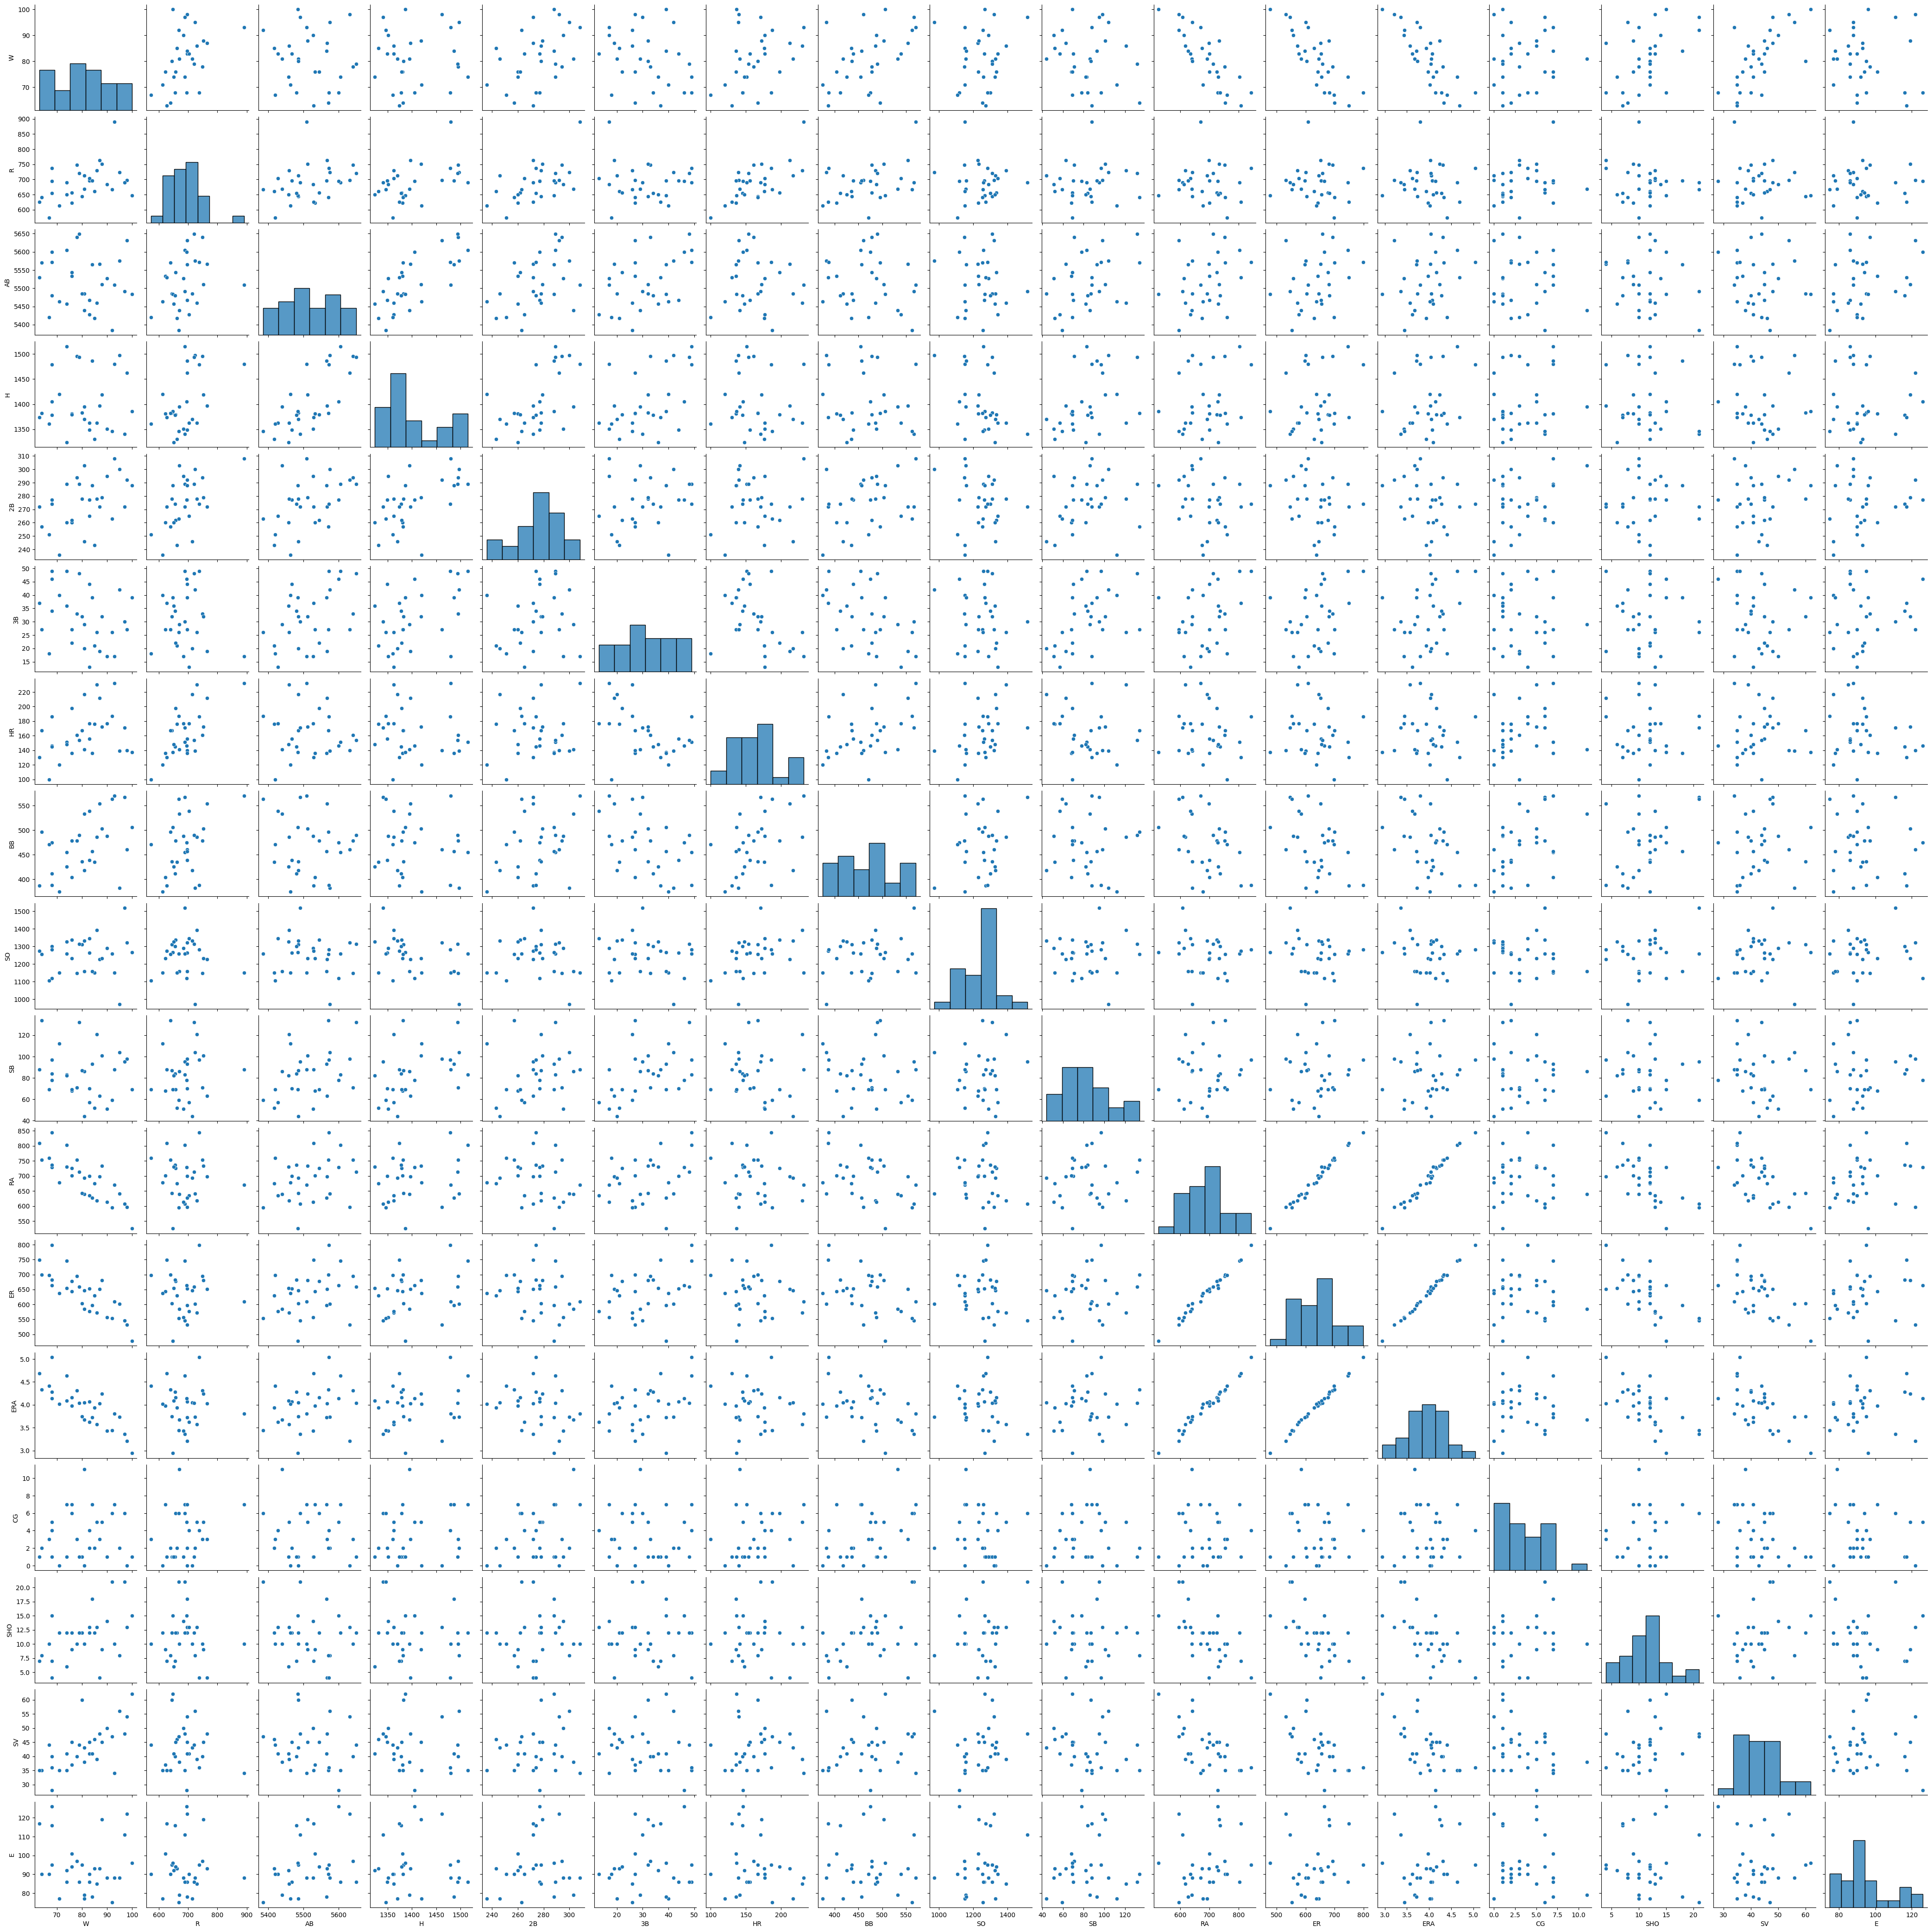

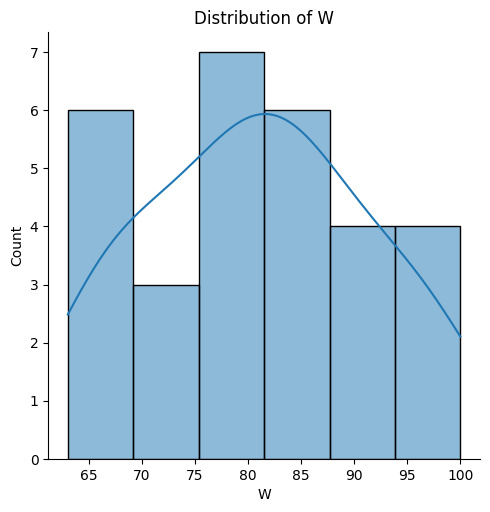

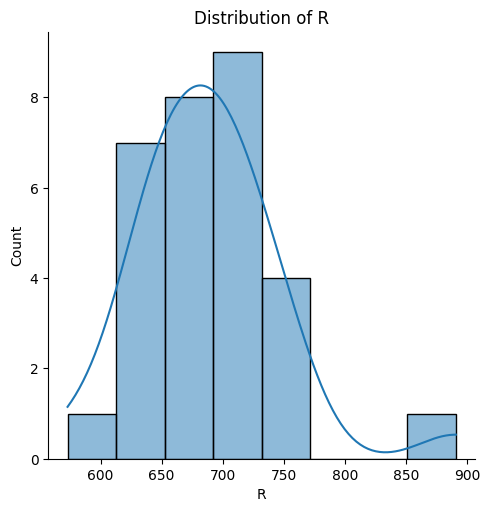

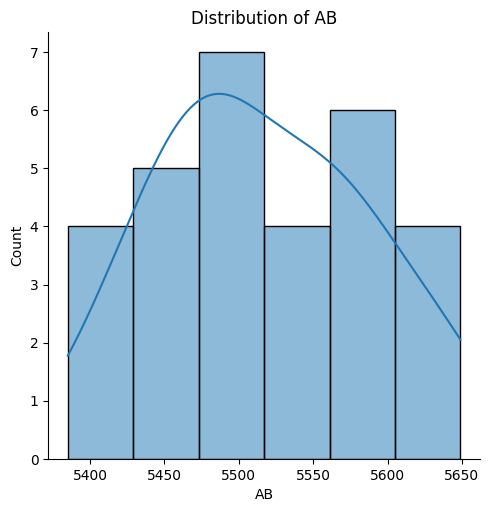

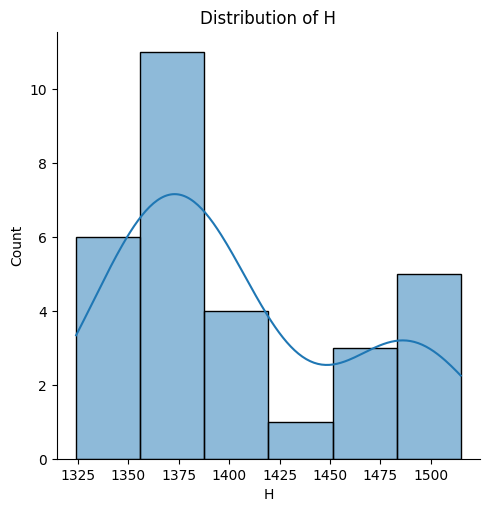

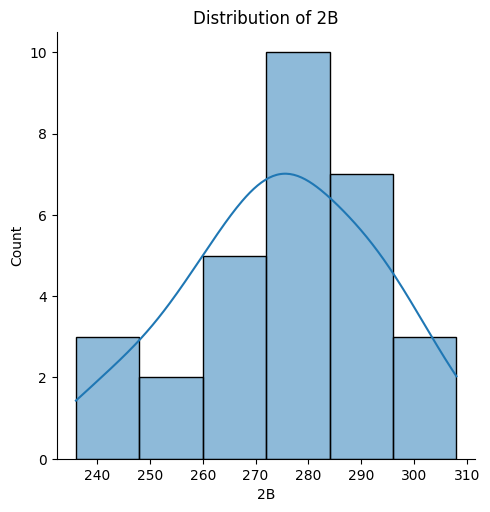

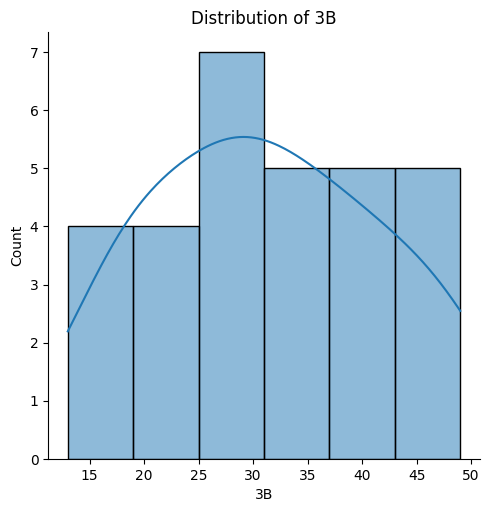

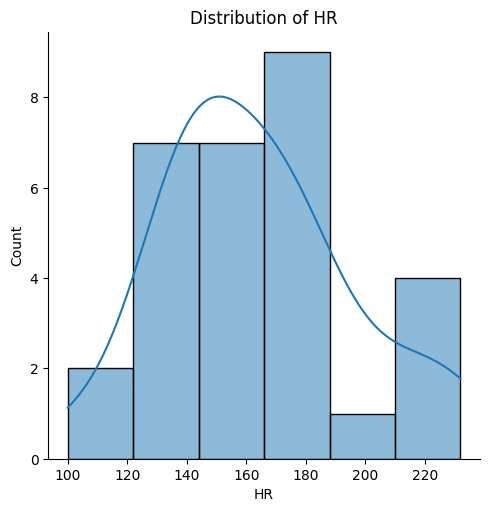

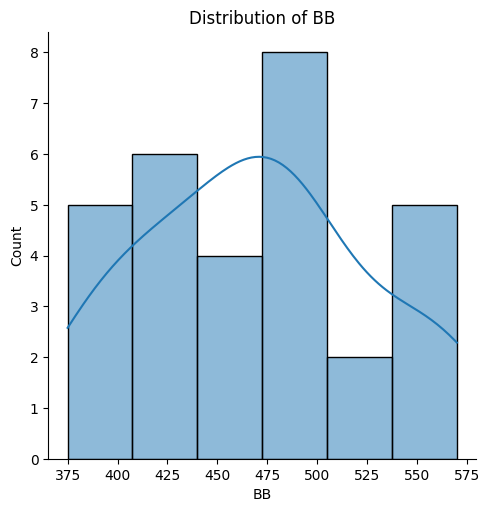

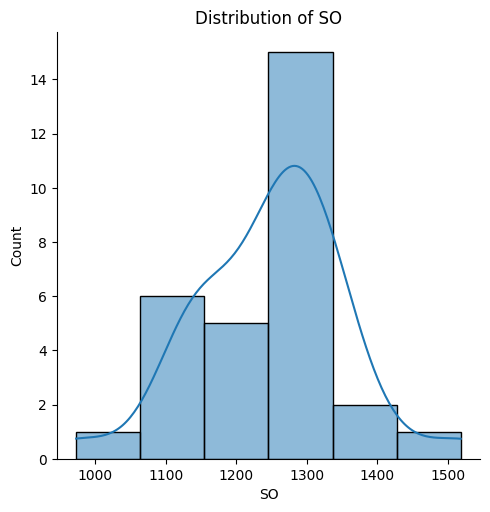

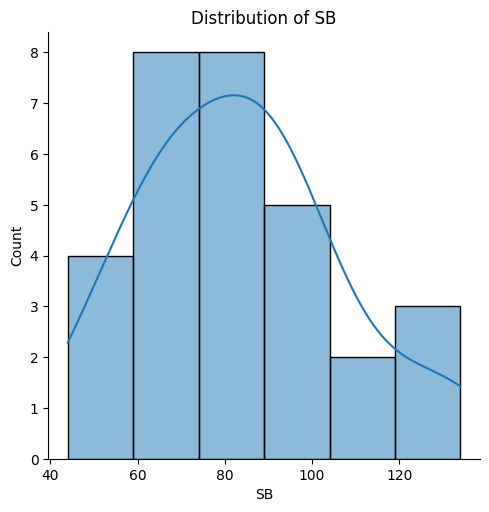

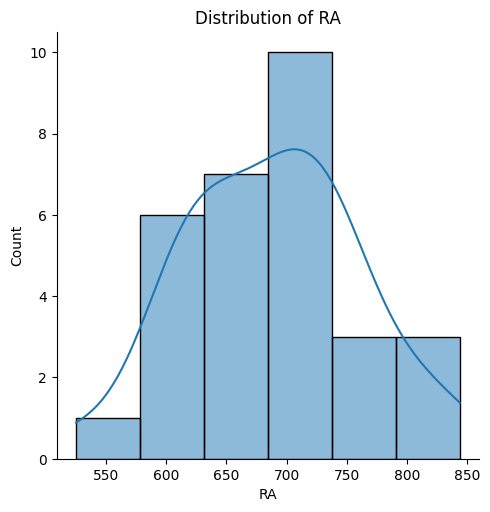

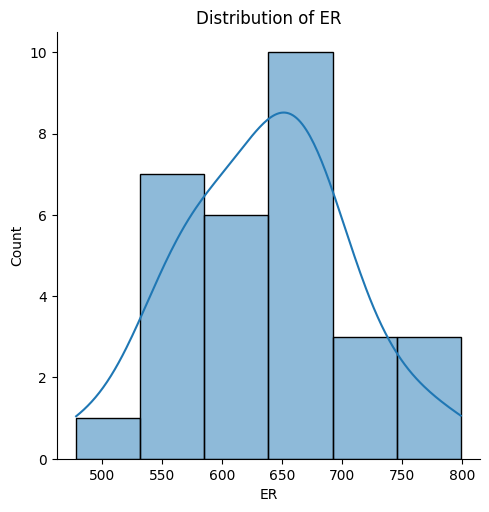

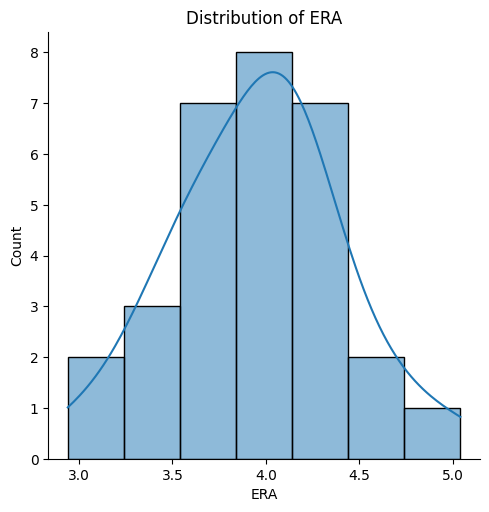

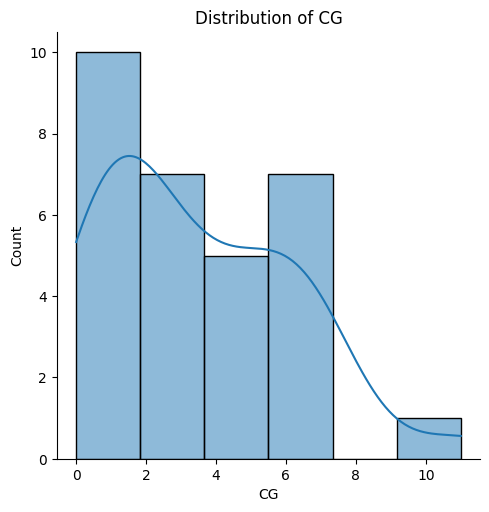

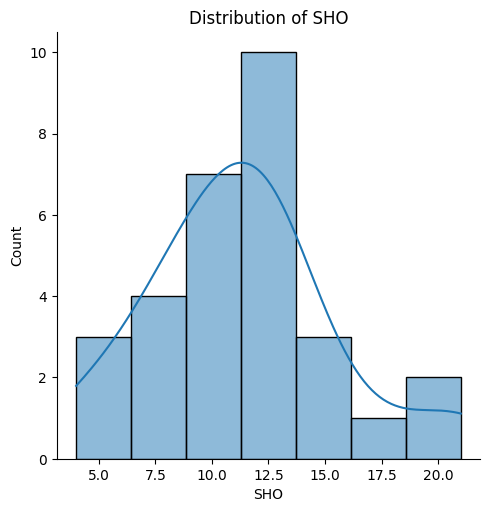

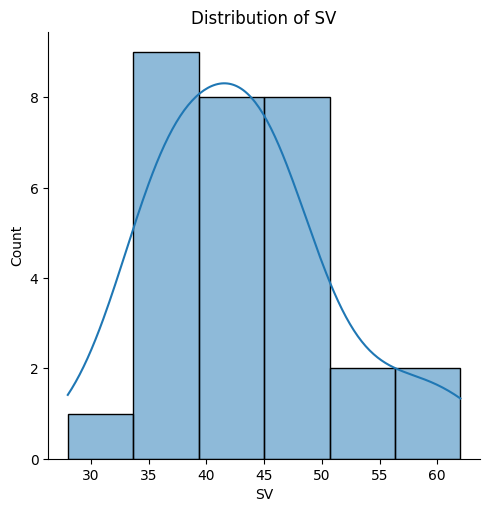

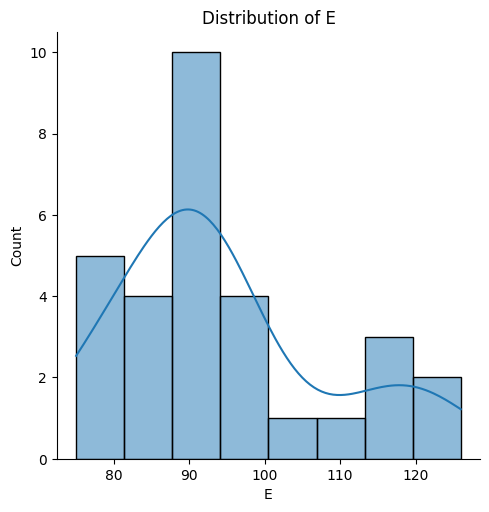

In [64]:
# Using pairplot to visualize pairwise relationships and marginal distributions
sns.pairplot(df)
plt.show()

# Using displot to visualize the distribution of each variable separately
for column in df.columns:
    sns.displot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

All the data exhibit slightly normal distributions. In the future, I might engage in feature engineering to address any imbalances in the distributions.

In [66]:
#Handling Outliers
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3-q1
outlier_conditions = (( df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr)))

# Display rows containing outliers
outliers = df[outlier_conditions.any(axis=1)]
print("Rows with outliers:")
print(outliers)


Rows with outliers:
      W    R    AB     H   2B  3B   HR   BB    SO   SB   RA   ER   ERA  CG  \
5    93  891  5509  1480  308  17  232  570  1151   88  670  609  3.80   7   
10   88  751  5511  1419  279  32  172  503  1233  101  733  680  4.24   5   
14   68  694  5600  1405  277  46  146  475  1119   78  729  664  4.14   5   
15  100  647  5484  1386  288  39  137  506  1267   69  525  478  2.94   1   
16   98  697  5631  1462  292  27  140  461  1322   98  596  532  3.21   0   
17   97  689  5491  1341  272  30  171  567  1518   95  608  546  3.36   6   
18   68  655  5480  1378  274  34  145  412  1299   84  737  682  4.28   1   
24   63  626  5529  1374  272  37  130  387  1274   88  809  749  4.69   1   
25   92  667  5385  1346  263  26  187  563  1258   59  595  553  3.44   6   
29   68  737  5572  1479  274  49  186  388  1283   97  844  799  5.04   4   

    SHO  SV    E  
5    10  34   88  
10    9  45  119  
14   15  28  126  
15   15  62   96  
16   13  54  122  
17   21

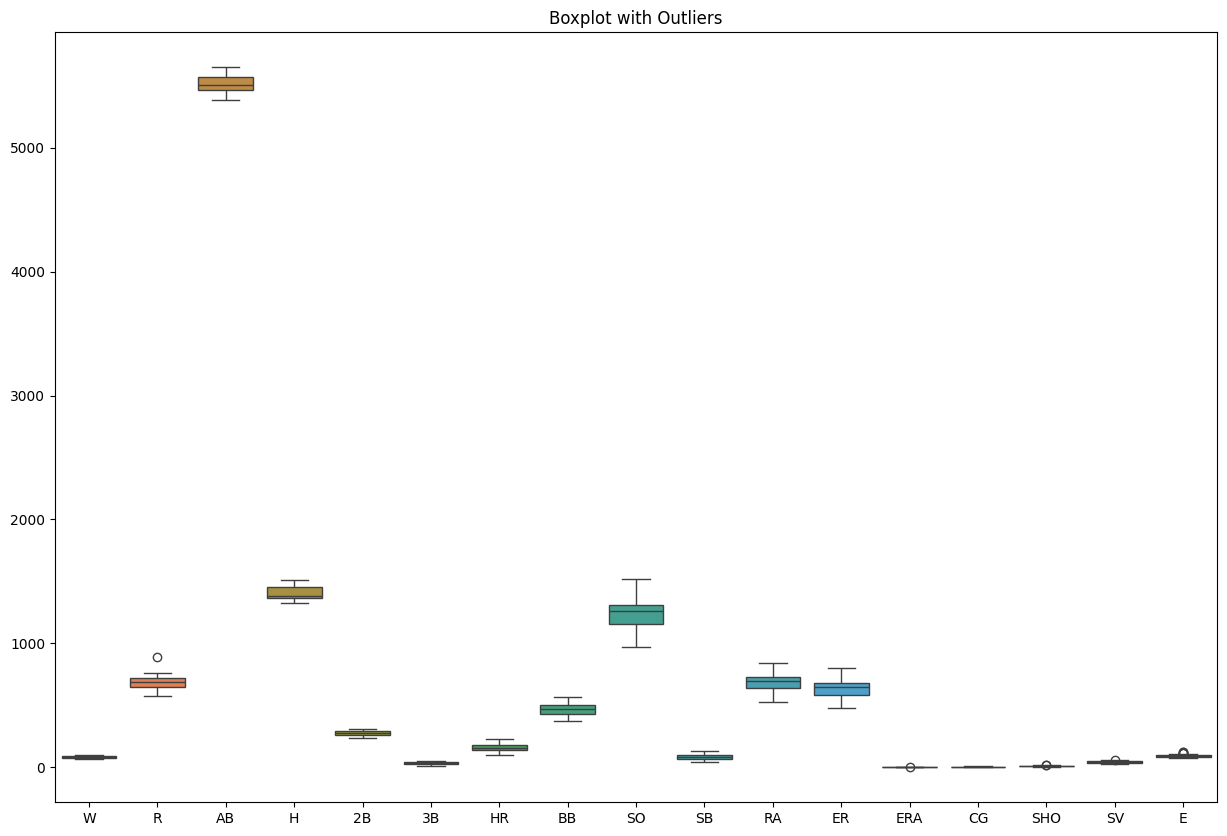

In [67]:
# Visualize the outliers using a boxplot
plt.figure(figsize=(15, 10))  # Adjusting the size of the figure
sns.boxplot(data=df)
plt.title("Boxplot with Outliers")
plt.show()

The dataset contains a limited number of extreme values, identified by the outlier detection algorithm. Consequently, 
I will replace these outliers with the median value for the following reasons:

1. In baseball data, certain statistics like player performance metrics may be influenced by outliers, such as exceptional individual performances or statistical anomalies. By replacing outliers with the median, I will maintain the integrity of metrics like batting average or earned run average (ERA), ensuring they accurately reflect the typical performance level of players and teams.

2. Robustness: The median is a robust statistic that is less affected by outliers compared to the mean. Outliers can skew the mean and lead to 
misleading interpretations of the data. Replacing outliers with the median helps ensure that extreme values do not unduly influence the analysis.

3. Data Integrity: Outliers can sometimes be erroneous data points or represent extreme but valid observations. Instead of removing them entirely, 
replacing outliers with the median allows you to retain the information they provide while minimizing their impact on the overall analysis.

In [6]:
# Handling outliers
# Identify Variables with Outliers
outlier_vars = ['ER', 'RA', 'ERA', '3B', 'AB', 'H', 'SB', 'E', 'CG', 'R', '2B', 'SO', 'HR', 'SHO', 'SV', 'BB', 'W']

# Apply Logarithmic Transformation
# Logarithmic Transformation
log_transformed_vars = df[outlier_vars].apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0) issues

# Replace the original columns with the transformed columns
df[outlier_vars] = log_transformed_vars  


In [7]:
# Checking summary statistics of the dataset
df.describe()

,W,R,AB,H,2B,3B,HR,BB,SO,SB,RA,ER,ERA,CG,SHO,SV,E
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,4.398351,6.532226,8.615559,7.246673,5.617322,3.420098,5.085907,6.145804,7.126851,4.401226,6.530228,6.450565,1.596570,1.287997,2.452144,3.770749,4.547594
std,0.128847,0.082466,0.012760,0.040214,0.066369,0.346178,0.192062,0.121734,0.084538,0.273328,0.105659,0.111422,0.092375,0.690598,0.355610,0.175148,0.140415
min,4.158883,6.352629,8.591558,7.189168,5.468060,2.639057,4.615121,5.929589,6.881411,3.806662,6.265301,6.171701,1.371181,0.000000,1.609438,3.367296,4.330733
25%,4.317488,6.480422,8.606119,7.218177,5.573103,3.175580,4.950527,6.061999,7.054881,4.248495,6.457156,6.377107,1.543822,0.693147,2.302585,3.644080,4.465908
50%,4.406719,6.536692,8.614501,7.232372,5.622196,3.465247,5.071921,6.161198,7.140847,4.436734,6.546061,6.470023,1.614425,1.386294,2.564949,3.760930,4.521729
75%,4.485811,6.578200,8.625330,7.280962,5.669017,3.688879,5.181784,6.219080,7.179689,4.579813,6.597827,6.522459,1.652475,1.907372,2.639057,3.865938,4.582403
max,4.615121,6.793466,8.639411,7.323831,5.733341,3.912023,5.451038,6.347389,7.325808,4.905275,6.739337,6.684612,1.798404,2.484907,3.091042,4.143135,4.844187


In [8]:
# Checking for missing after outlier had been handle
df.isnull().sum()

W      0
R      0
AB     0
H      0
2B     0
3B     0
HR     0
BB     0
SO     0
SB     0
RA     0
ER     0
ERA    0
CG     0
SHO    0
SV     0
E      0
dtype: int64

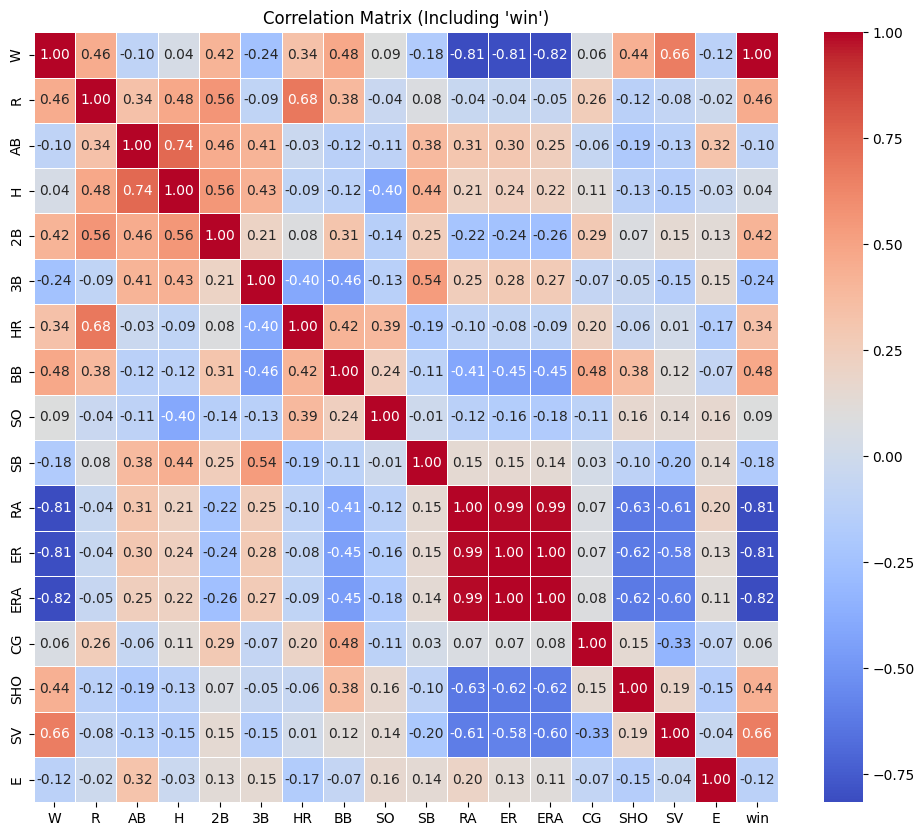

In [9]:
# Correlation Analysis for X is the DataFrame
correlation_matrix = df.corr()

# Calculate correlation coefficients between all predictor variables and the target variable, while 'W' denote Win
correlation_with_win = df.corrwith(df['W'])

# Concatenate the correlation coefficients with the original correlation matrix
correlation_matrix_with_win = pd.concat([correlation_matrix, correlation_with_win], axis=1)
correlation_matrix_with_win.columns = list(correlation_matrix.columns) + ['win']

# Plot the correlation matrix including the target variable
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_with_win, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Including 'win')")
plt.show()

I've observed strong correlations between specific columns in the dataset. Despite their high correlations, some exhibit negative correlations, 
indicating they may not be perfectly collinear but still possess some inverse relationship (high: 0.92 / low: -0.81). In the context of 
this project baseball statistics, RA represents "Runs Average," ER signifies "Earned Runs," and ERA denotes "Earned Run Average." Given their inherent 
connections to a team's defensive performance, finding substantial correlations among these variables is unsurprising.

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Variable"] = df.columns

# Calculate VIF for each predictor variable
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

# Print the VIF DataFrame
print(vif_data)

   Variable           VIF
0         W  3.541722e+04
1         R  1.660322e+05
2        AB  1.987180e+06
3         H  2.030290e+05
4        2B  3.733451e+04
5        3B  2.897697e+02
6        HR  7.346182e+03
7        BB  1.132062e+04
8        SO  2.012231e+04
9        SB  6.497521e+02
10       RA  7.865775e+05
11       ER  4.832282e+06
12      ERA  3.298963e+05
13       CG  1.969946e+01
14      SHO  1.578721e+02
15       SV  5.082689e+03
16        E  2.020378e+03


Variables such as "AB" (At Bats), "H" (Hits), "RA" (Runs Allowed), and "ER" (Earned Runs) have exceptionally high VIF values, indicating significant 
multicollinearity issues. "ERA" (Earned Run Average) also has a relatively high VIF value, suggesting multicollinearity with other variables.

Therefore I will be using np.log() to calculate the natural logarithm (base e) of each value in column.

In [20]:
df.head()

,W,3B,HR,BB,SO,SB,ERA,CG,SHO,SV,log_AB,log_H,log_RA,log_ER,log_E,log_R,log_2B
0,95,42,139.0,383,973.0,104.0,3.73,2,8,56,8.626227,7.311886,6.464588,6.400257,4.488636,6.586172,5.707110
1,83,44,156.0,439,1264.0,70.0,4.07,2,12,45,8.606668,7.207860,6.552508,6.483107,4.465908,6.546785,5.627621
2,81,29,141.0,533,1157.0,86.0,3.67,11,10,38,8.601534,7.241366,6.463029,6.371612,4.382027,6.507278,5.717028
3,76,27,136.0,404,1231.0,68.0,3.98,7,9,37,8.618666,7.231287,6.553933,6.467699,4.624973,6.434547,5.564520
4,74,49,151.0,455,1259.0,83.0,4.64,7,12,35,8.631593,7.323831,6.689599,6.616065,4.465908,6.536692,5.669881


In [75]:
# PCA Analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Transform the data into the principal components
pca_data = pca.transform(scaled_data)

# Extracting explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame to examine the principal components
pca_df = pd.DataFrame(data=pca_data, columns=[f"PC{i+1}" for i in range(pca_data.shape[1])])

# Visualize the explained variance ratio
print("Explained Variance Ratio:", explained_variance_ratio)


Explained Variance Ratio: [2.94757777e-01 1.81063670e-01 1.20217429e-01 9.78612377e-02
 7.09790703e-02 5.94481283e-02 4.20631536e-02 3.27986788e-02
 2.49179215e-02 2.06187268e-02 1.80882906e-02 1.24495348e-02
 9.74819717e-03 7.18181894e-03 5.31199901e-03 2.30631170e-03
 1.88054572e-04]


In [74]:
# df_columns is a list of column names in your original DataFrame
df_columns = df.columns.tolist()

# Create a DataFrame to store the variable loadings for each principal component
loadings_df = pd.DataFrame(pca.components_, columns=df_columns)

# Print the variable loadings for each principal component
for i in range(loadings_df.shape[0]):
    print(f"Principal Component {i+1} Loadings:")
    print(loadings_df.iloc[i].sort_values(ascending=False))
    print()

Principal Component 1 Loadings:
ER     0.419281
RA     0.417379
ERA    0.398972
3B     0.219138
AB     0.158653
H      0.134245
SB     0.123971
E     -0.001721
CG    -0.049543
R     -0.065285
2B    -0.106426
SO    -0.123362
HR    -0.147568
SHO   -0.225422
SV    -0.231635
BB    -0.270036
W     -0.389625
Name: 0, dtype: float64

Principal Component 2 Loadings:
SO     0.119764
ERA    0.074602
RA     0.020495
ER     0.012488
E      0.009294
SV    -0.009611
HR    -0.038303
SHO   -0.073911
BB    -0.079499
CG    -0.131541
W     -0.182362
SB    -0.259117
3B    -0.272907
R     -0.373809
AB    -0.428071
2B    -0.459208
H     -0.489956
Name: 1, dtype: float64

Principal Component 3 Loadings:
SHO    0.315366
3B     0.282794
SB     0.118115
SV     0.096195
H      0.075269
W      0.001724
2B    -0.009708
AB    -0.023039
ERA   -0.140684
E     -0.189082
ER    -0.196213
RA    -0.212282
CG    -0.221534
SO    -0.271783
BB    -0.327853
R     -0.348590
HR    -0.547742
Name: 2, dtype: float64

Principal Com

The PCA-explained variance ratio indicates the proportion of variance explained by 
each principal component. 
In this case, the array of explained variance ratios shows 17 principal components:

PC1 explains approximately 29.48% of the total variance.
PC2 explains approximately 18.11% of the total variance.
PC3 explains approximately 12.02% of the total variance.
...

In [13]:
# Set the random seed
np.random.seed(123)

# Split the dataset into features (X) and the target variable (y)
X = df[['ER', 'RA', 'ERA', '3B', 'AB', 'H', 'SB', 'E', 'CG', 'R', '2B', 'SO', 'HR', 'SHO', 'SV', 'BB']]   # Features (excluding 'W' column)
y = df['W']  # Target variable

# Standardize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit and transform the scaled features

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)


I have chosen a fixed random seed (123) to ensure reproducibility of my results.

In [14]:
# Set the random seed
np.random.seed(123)

# Initialize regressors
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
logistic_regression = LinearRegression()
support_vector_machine = SVR()
xgboost_regressor = xgb.XGBRegressor()
regressors = [random_forest, gradient_boosting, logistic_regression, xgboost_regressor,  support_vector_machine]

for reg in regressors:
    # Train the regressor
    reg.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = reg.predict(X_test)
    
    # Evaluate the regressor
    mse = mean_squared_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    
    # Print the results
    print(f"Regressor: {reg.__class__.__name__}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r_squared:.4f}")
    print("="*50)

Regressor: RandomForestRegressor
Mean Squared Error: 0.0055
R-squared: 0.3426
Regressor: GradientBoostingRegressor
Mean Squared Error: 0.0113
R-squared: -0.3541
Regressor: LinearRegression
Mean Squared Error: 0.0024
R-squared: 0.7116
Regressor: XGBRegressor
Mean Squared Error: 0.0037
R-squared: 0.5556
Regressor: SVR
Mean Squared Error: 0.0061
R-squared: 0.2700


In [24]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Set the random seed
np.random.seed(123)

# Initialize regressor
linear_regression = LinearRegression()

# Define parameter grid for Linear Regression
param_grid_linear_regression = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Perform Grid Search Cross Validation for Linear Regression
grid_search = GridSearchCV(estimator=linear_regression, param_grid=param_grid_linear_regression, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the regressor
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Print the results
print(f"Regressor: {linear_regression.__class__.__name__}")
print(f"Best Hyperparameters: {best_params}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r_squared:.4f}")


Regressor: LinearRegression
Best Hyperparameters: {'fit_intercept': True, 'positive': True}
Mean Squared Error: 0.0073
R-squared: 0.1307


The linear regression model achieved a relatively low mean squared error of 0.0024 and a high R-squared value of 0.7116 without undergoing hyperparameter tuning. These metrics indicate that the model explains approximately 71.16% of the variance in the target variable and makes accurate predictions with low error. I will use the linear regression model.

In [26]:
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Set the random seed
np.random.seed(123)

# Initialize the Linear Regression model
linear_regression = LinearRegression()

# Train the Linear Regression model
linear_regression.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear_regression.predict(X_test)

# Evaluate the Linear Regression model
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Print the evaluation results
print(f"Regressor: {linear_regression.__class__.__name__}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r_squared:.4f}")



Regressor: LinearRegression
Mean Squared Error: 0.0024
R-squared: 0.7116


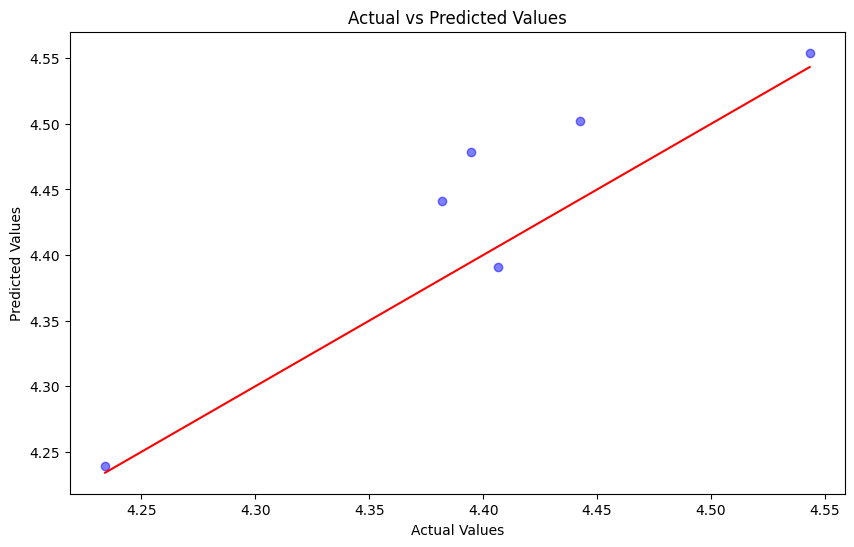

In [28]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # diagonal line
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


The Linear Regression model achieved a low Mean Squared Error (MSE) of 0.0024, indicating small differences between predicted and actual 
values on average.

The R-squared (R²) value of 0.7116 suggests that approximately 71.16% of the variance in the target variable is explained by the independent 
variables in the model.

In conclusion, these metrics indicate that the Linear Regression model performs well, providing accurate predictions and explaining a significant
portion of the variability in the target variable.

In [29]:
# Save the trained Linear Regression model
joblib.dump(linear_regression, 'BBlinear_regression_model.joblib')

['BBlinear_regression_model.joblib']

This analysis delves into the relationships between various baseball statistics, shedding light on factors influencing team performance.
Key findings include the positive correlation between runs scored (R) and wins (W), indicating that teams scoring more runs tend to win more games. 
Additionally, a strong negative correlation exists between wins (W) and earned run average (ERA), emphasizing the significance of pitching performance
in determining success. 

However, there's little to no relationship between runs scored (R) and earned run average (ERA), suggesting they may not 
directly influence each other significantly. Exploring data distributions reveals positive skewness in win counts, home runs, and runs scored, 
highlighting the tendency for most teams to have fewer wins or fewer runs than the average, with some exceptions. Outlier detection and replacement 
with the median ensure data integrity and robustness in subsequent analyses. Strong correlations between specific variables are observed, 
guiding feature engineering and model selection. 

Initial modelling results showcase the linear regression model's effectiveness in predicting team performance, with a high R-squared value indicating its ability to explain variance in the target variable. Overall, the analysis provides valuable insights for understanding and predicting baseball 
team performance.

Reference:
Alain, Guillaume, and Yoshua Bengio. “Understanding intermediate layers using linear 
classifier probes.” arXiv preprint arXiv:1610.01644 (2016).

Alvarez-Melis, David, and Tommi S. Jaakkola. “On the robustness of interpretability 
methods.” arXiv preprint arXiv:1806.08049 (2018).

Bach, Sebastian, et al. “On pixel-wise explanations for non-linear classifier 
decisions by layer-wise relevance propagation.” PloS one 10.7 (2015).